In [23]:
# Miscellaneous operating system interfaces
import os

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd
import scipy

# Libraries for plotting and geospatial data visualisation
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# To work with data labels in dictionary format
from collections import OrderedDict

# Date and time related libraries
from dateutil.relativedelta import relativedelta
from calendar import monthrange
from datetime import datetime

# Interactive HTML widgets
import ipywidgets as widgets

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

# Copy files to another path directory
import shutil

import numba

import xskillscore as xs
import scipy

#!pip install cftime
import cftime

#!pip install climpred
import climpred
from climpred import HindcastEnsemble

#I had to reinstall cftime to get all the packages
#conda install -c conda-forge cftime
#conda install -c conda-forge xarray

In [24]:
datadir = 'C:/Users/apedregal/Documents/inventWater_docs/Modelling/Seasonal forecasts/'
station = "C2"
variable="tp"

# ERA5

In [25]:
# Load ERA5 observed data
era5_obs = pd.read_csv(f"{datadir}reanalysis/reanalysis_daily_{station}_all_withDates.csv", sep=" ", parse_dates=['time'])
era5_obs = era5_obs.set_index('time')

# Filter data starting from 1993
era5_obs = era5_obs[era5_obs.index.year >= 1993]
era5_obs = era5_obs[variable]

In [26]:
# Assuming your data is in a pandas Series named 't2m' with a datetime index.
era5_obs.index = pd.to_datetime(era5_obs.index)  # Ensure the index is datetime

In [27]:
# Resample to monthly frequency, calculating the mean for each month
monthly_obs = era5_obs.resample('MS').mean()  # 'MS' ensures the date is set to the 1st of each month

In [28]:
# Generate cftime_range
try:
    cftime_times = xr.cftime_range(
        start=str(monthly_obs.index[0]),  # Use the first date in the index
        periods=len(monthly_obs.index),  # Match the number of time steps
        freq="MS",                       # Monthly frequency
        calendar="360_day"               # 360-day calendar
    )
    print("cftime_range created successfully:", cftime_times)
except Exception as e:
    print("Error with cftime_range:", e)

cftime_range created successfully: CFTimeIndex([1993-01-01 00:00:00, 1993-02-01 00:00:00, 1993-03-01 00:00:00,
             1993-04-01 00:00:00, 1993-05-01 00:00:00, 1993-06-01 00:00:00,
             1993-07-01 00:00:00, 1993-08-01 00:00:00, 1993-09-01 00:00:00,
             1993-10-01 00:00:00,
             ...
             2023-03-01 00:00:00, 2023-04-01 00:00:00, 2023-05-01 00:00:00,
             2023-06-01 00:00:00, 2023-07-01 00:00:00, 2023-08-01 00:00:00,
             2023-09-01 00:00:00, 2023-10-01 00:00:00, 2023-11-01 00:00:00,
             2023-12-01 00:00:00],
            dtype='object', length=372, calendar='360_day', freq='MS')


In [29]:
# Convert the monthly pandas Series to an xarray Dataset
ds_obs = xr.Dataset(
    {
        variable: (["time"], monthly_obs.values)
    },
    coords={
        "time": xr.cftime_range(
    start=str(monthly_obs.index[0]), periods=len(monthly_obs.index), freq="MS", calendar="360_day")
    }
)

In [30]:
ds_obs

<xarray.Dataset> Size: 6kB
Dimensions:  (time: 372)
Coordinates:
  * time     (time) object 3kB 1993-01-01 00:00:00 ... 2023-12-01 00:00:00
Data variables:
    tp       (time) float64 3kB 0.1223 3.144 2.859 4.497 ... 1.631 1.347 0.6848

# SEAS5

In [31]:
# Function to load SEAS5 data for a given member, year, and month, and create monthly values for the 7 predicted months
def load_seas5_data_monthly(member, year, month):
    file_path = f"{datadir}seasonal/hindcast_bc/hindcast_bc_{station}/hind_{station}_{variable}_member{member}_year{year-1993}_month{month}.csv"
    seas5_daily = pd.read_csv(file_path, header=None).values.flatten()
    date_fore = pd.date_range(datetime.strptime(str(year) + "-" + str(month+1) + "-" +"01", "%Y-%m-%d"), periods =215)
    df = pd.DataFrame({"date":date_fore,"value":seas5_daily})
    # Convert 'date' to datetime
    df['date'] = pd.to_datetime(df['date'])
    # Add year-month and day columns
    df['year_month'] = df['date'].dt.to_period('M')
    df['day'] = df['date'].dt.day
    # Get days in each month
    days_in_month = df['date'].dt.days_in_month
    # Check for completed months
    df['is_complete'] = df.groupby('year_month')['day'].transform('count') == days_in_month
    # Filter only complete months
    complete_months_df = df[df['is_complete']]
    # Calculate monthly mean for complete months
    monthly_means = complete_months_df.groupby('year_month')['value'].mean()
    return monthly_means

In [32]:
# Define the period and members
years = np.arange(1993, 2017)
months = np.arange(0, 12)
n_members = 25
n_months = 7

# Load all SEAS5 data into a structured format (lead, init, member)
seas5_data = np.zeros((n_months, len(np.arange(1993, 2017))*12, n_members))
init_dates = []  # List to store init_date values

# Load data
for member in range(0, n_members):
    init = 0  # Initialization index
    for year in years:
        for month in months:
            # Generate initialization date
            init_date = datetime.strptime(f"{year}-{month + 1:02d}-01", "%Y-%m-%d")
            init_dates.append(init_date)  # Save init_date
            
            # Load the data for this member, year, and month
            monthly_data = load_seas5_data_monthly(member, year, month)
            
            # Populate the data array
            for lead in range(0, n_months):
                seas5_data[lead, init, member] = monthly_data.iloc[lead]
            init += 1

In [33]:
# Convert init_dates to numpy array
init_dates_np = np.array(init_dates)
init_dates_np = np.unique(init_dates_np)
init_dates_cftime = xr.cftime_range(
    start=str(np.unique(init_dates_np)[0]), periods=len(init_dates_np), freq="MS", calendar="360_day"
)

In [34]:
seas5_data.shape

(7, 288, 25)

In [35]:
# Convert the monthly pandas Series to an xarray Dataset
ds_fcst = xr.Dataset(
    {
        variable: (["lead", "init", "member"], seas5_data)
    },
    coords={
        "lead": range(0,n_months),
        "init": init_dates_cftime,
        "member": range(0, n_members)
    }
)

In [36]:
ds_fcst

<xarray.Dataset> Size: 406kB
Dimensions:  (lead: 7, init: 288, member: 25)
Coordinates:
  * lead     (lead) int32 28B 0 1 2 3 4 5 6
  * init     (init) object 2kB 1993-01-01 00:00:00 ... 2016-12-01 00:00:00
  * member   (member) int32 100B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
Data variables:
    tp       (lead, init, member) float64 403kB 1.59 3.8 1.741 ... 3.19 3.065

In [36]:
# THIS CODE IS THE SAME AS ABOVE BUT FOR PREVIOUS FILENAMES OF HINDCAST tp

'''# Function to load SEAS5 data for a given member, year, and month, and create monthly values for the 7 predicted months
def load_seas5_data_monthly(member, year, month):
    # Calculate the 'file' index corresponding to the year and month
    file = (year - 1993) * 12 + month  # file index ranging from 0 to 187
    
    # Construct the file path with the new file naming convention
    file_path = f"{datadir}seasonal/hindcast_bc/hindcast_bc_{station}/hind_{station}_{variable}_member{member}_time{file}.csv"
    
    # Load the data from the file
    seas5_daily = pd.read_csv(file_path, header=None).values.flatten()
    
    # Create a date range starting from the first day of the month
    date_fore = pd.date_range(datetime.strptime(f"{year}-{month+1:02d}-01", "%Y-%m-%d"), periods=215)
    
    # Create DataFrame
    df = pd.DataFrame({"date": date_fore, "value": seas5_daily})
    
    # Convert 'date' to datetime and add additional columns
    df['date'] = pd.to_datetime(df['date'])
    df['year_month'] = df['date'].dt.to_period('M')
    df['day'] = df['date'].dt.day
    
    # Get the number of days in each month
    days_in_month = df['date'].dt.days_in_month
    
    # Mark complete months (with all days in the month)
    df['is_complete'] = df.groupby('year_month')['day'].transform('count') == days_in_month
    
    # Filter for complete months only
    complete_months_df = df[df['is_complete']]
    
    # Calculate monthly means for the complete months
    monthly_means = complete_months_df.groupby('year_month')['value'].mean()
    
    return monthly_means

In [37]:
'''# Define the period and members
years = np.arange(1993, 2017)
months = np.arange(0, 12)
n_members = 25
n_months = 7

# Initialize the data array and list for init dates
seas5_data = np.zeros((n_months, len(np.arange(1993, 2017)) * 12, n_members))
init_dates = []  # List to store initialization dates

# Load the data
for member in range(0, n_members):
    init = 0  # Initialization index for time steps
    for year in years:
        for month in months:
            # Generate initialization date for the given year and month
            init_date = datetime.strptime(f"{year}-{month + 1:02d}-01", "%Y-%m-%d")
            init_dates.append(init_date)  # Store the initialization date
            
            # Load the monthly data for the given member, year, and month
            monthly_data = load_seas5_data_monthly(member, year, month)
            
            # Populate the data array for the n_months lead time
            for lead in range(0, n_months):
                seas5_data[lead, init, member] = monthly_data.iloc[lead]
            
            init += 1  # Increment initialization index

In [38]:
'''# Convert init_dates to numpy array
init_dates_np = np.array(init_dates)
init_dates_np = np.unique(init_dates_np)
init_dates_cftime = xr.cftime_range(
    start=str(np.unique(init_dates_np)[0]), periods=len(init_dates_np), freq="MS", calendar="360_day"
)


In [39]:
'''# Convert the monthly pandas Series to an xarray Dataset
ds_fcst = xr.Dataset(
    {
        variable: (["lead", "init", "member"], seas5_data)
    },
    coords={
        "lead": range(0,n_months),
        "init": init_dates_cftime,
        "member": range(0, n_members)
    }
)

In [40]:
'''ds_fcst

<xarray.Dataset>
Dimensions:  (lead: 7, init: 288, member: 25)
Coordinates:
  * lead     (lead) int32 0 1 2 3 4 5 6
  * init     (init) object 1993-01-01 00:00:00 ... 2016-12-01 00:00:00
  * member   (member) int32 0 1 2 3 4 5 6 7 8 9 ... 16 17 18 19 20 21 22 23 24
Data variables:
    tp       (lead, init, member) float64 1.456 3.134 2.623 ... 2.389 2.849 2.97

# Start verification

In [37]:
fcstds = ds_fcst.sel(init=slice("1993-01-01", "2016-12-01"))
verifds = ds_obs.sel(time=slice("1993-01-01", "2016-12-01"))

In [38]:
fcstds["lead"].attrs["units"] = "months"

In [39]:
fcstds

<xarray.Dataset> Size: 406kB
Dimensions:  (lead: 7, init: 288, member: 25)
Coordinates:
  * lead     (lead) int32 28B 0 1 2 3 4 5 6
  * init     (init) object 2kB 1993-01-01 00:00:00 ... 2016-12-01 00:00:00
  * member   (member) int32 100B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
Data variables:
    tp       (lead, init, member) float64 403kB 1.59 3.8 1.741 ... 3.19 3.065

In [67]:
verifds["time"]

<xarray.DataArray 'time' (time: 288)> Size: 2kB
array([cftime.Datetime360Day(1993, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1993, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(1993, 3, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.Datetime360Day(2016, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2016, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(2016, 12, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2kB 1993-01-01 00:00:00 ... 2016-12-01 00:00:00

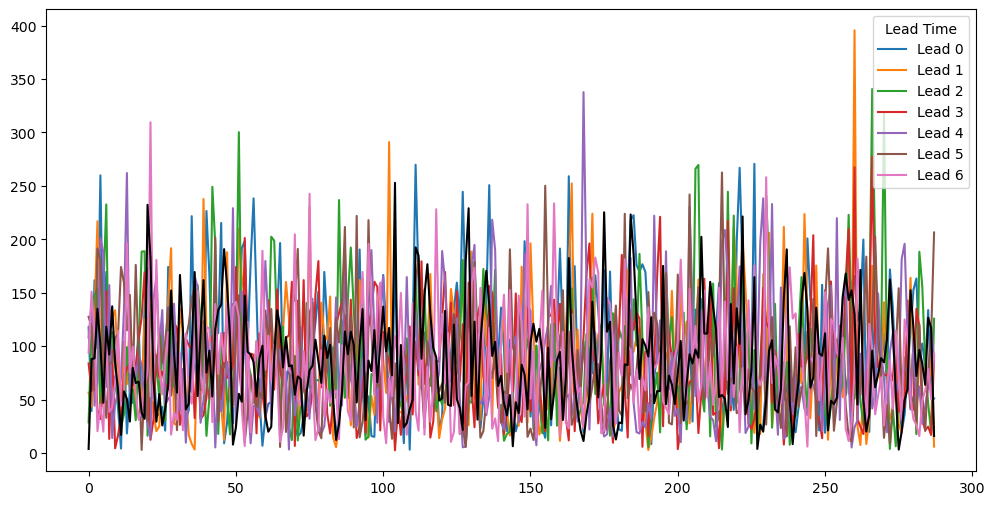

In [68]:
#Comparing obs vs forecast for one member (checking before calculating skill)
tp_member = fcstds.sel(member=1)
plt.figure(figsize=(12, 6))

for lead in tp_member["lead"].values:  # Iterate through lead times
    plt.plot(
        tp_member.sel(lead=lead)[variable],
        label=f"Lead {lead}"
    )
plt.plot(verifds[variable], "black")
plt.legend(title="Lead Time")

## Calculate the skill

In [40]:
hindcast = climpred.HindcastEnsemble(fcstds).add_observations(verifds)
alignment = "same_inits"#"same_inits"#"maximize"#"same_inits"
skill = hindcast.verify(metric='crpss', comparison='m2o', dim=['init','member'], alignment=alignment, groupby='month')

C:\Users\apedregal\Anaconda3\lib\site-packages\xskillscore\core\probabilistic.py:116: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if xmu.dims != observations.dims:
C:\Users\apedregal\Anaconda3\lib\site-packages\xskillscore\core\probabilistic.py:118: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if xsig.dims != observations.dims:
C:\Users\apedregal\Anaconda3\lib\site-packages\xskillscore\core\probabilistic.py:116: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a 

In [41]:
skill

<xarray.Dataset> Size: 840B
Dimensions:  (month: 12, lead: 7)
Coordinates:
  * lead     (lead) int32 28B 0 1 2 3 4 5 6
    skill    <U11 44B 'initialized'
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tp       (month, lead) float64 672B 0.2162 -0.08587 ... -0.1587 -0.2038
Attributes:
    prediction_skill_software:     climpred https://climpred.readthedocs.io/
    skill_calculated_by_function:  HindcastEnsemble.verify()
    number_of_initializations:     24
    number_of_members:             25
    alignment:                     same_inits
    metric:                        crpss
    comparison:                    m2o
    dim:                           ['init', 'member']
    reference:                     []

# Plot all CRPSS values for each month and lead time

Text(0, 0.5, 'Lead Time (Months)')

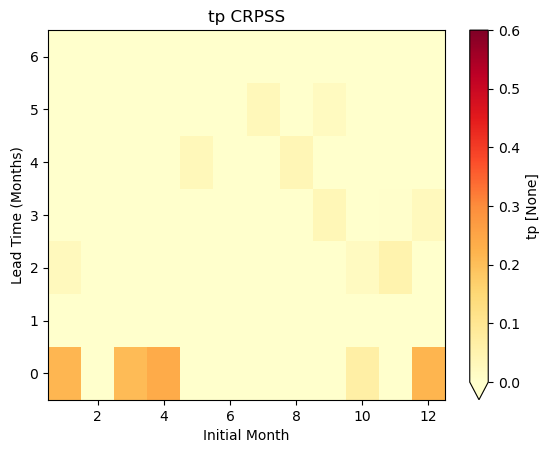

In [42]:
skill[variable].plot(y="lead", cmap="YlOrRd", 
                     vmin=0.0, vmax=0.6)
plt.title(variable + ' CRPSS')
plt.xlabel('Initial Month')
plt.ylabel('Lead Time (Months)')

## Example for CRPSS values for January:

In [72]:
skill[variable][0,:].values   #from January (0) to December (11)

array([ 0.2162222 , -0.08747934,  0.02781595, -0.06289918, -0.13778848,
       -0.19072917, -0.23206685])

## Customize the plot 

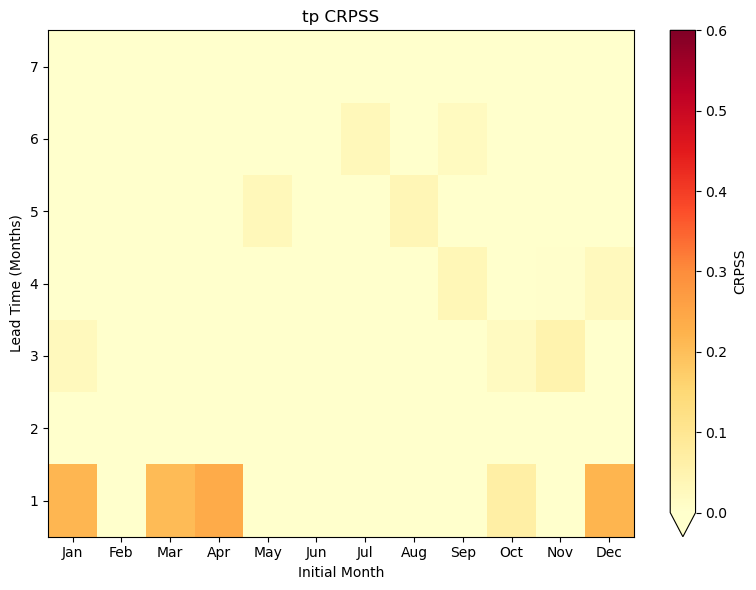

In [43]:
# Define the abbreviated month names
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Ensure Lead Time and Initial Month have the correct labels
skill = skill.assign_coords(
    lead=range(1, 8),  # Lead Time from 1 to 7
    month=range(1, 13)  # Initial Months from 1 to 12
)

# Create a new figure and axis to explicitly control the rendering
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed

# Plot CRPSS as a heatmap
skill[variable].plot(
    x='month',  # Initial Month on the x-axis
    y='lead',   # Lead Time on the y-axis
    cmap='YlOrRd',  # Colormap
    vmin=0.0,  # Minimum color range
    vmax=0.6,  # Maximum color range
    cbar_kwargs={'label': 'CRPSS'}  # Add a color bar label
)

# Add plot labels and title
plt.title(f"{variable} CRPSS")  # Title with variable name
plt.xlabel("Initial Month")  # X-axis label
plt.ylabel("Lead Time (Months)")  # Y-axis label

# Set custom tick marks for Initial Month (1 to 12) and Lead Time (1 to 7)
plt.xticks(ticks=range(1, 13), labels = month_labels)  # Show all months
plt.yticks(ticks=range(1, 8), labels=range(1, 8))  # Show lead times 1 to 7

# Adjust layout to avoid clipping
plt.tight_layout()

#Export plot
plt.savefig(f"{datadir}/seasonal/hindcast_skill/skill_crpss_FINAL_{variable}.svg", dpi=300, bbox_inches='tight')  # Save as a high-resolution PNG file

# Show the plot
plt.show()


## Export data

In [44]:
#Export data
df = skill.to_dataframe().reset_index()
# Export to CSV
df.to_csv(f"{datadir}/seasonal/hindcast_skill/skill_crpss_FINAL_{variable}.csv", index=False)